# MNIST DCGAN

This exercise uses modified DCGAN architecture to generate random MNIST digit image.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.modules
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

print("Pytorch version:",torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Pytorch version: 0.4.0


# Data

The MNIST data is PIL image range from 0 to 1. We'll transform them to range [-1, 1]. The image size is 28x28 grayscale, therefore each minibatch will have shape (128, 1, 28, 28)

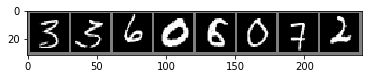

    3     3     6     0     6     0     7     2


Process Process-3:
Process Process-4:
Process Process-1:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    

In [2]:
batch_size = 100
labels_dim = 10

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show some images
imshow(torchvision.utils.make_grid(images[0:8]))
# print labels
print(' '.join('%5s' % labels[j].numpy() for j in range(8)))

# Generator Network

For each minibatch, the purpose of G (short of generator) is to take random noise as input and generate image with shape (1,28,28). In here, we're going to use transpose convolutional layer as proposed in DCGAN to upscale the tensors to finally match the intended image dimension. You can read more on transpose conv in https://arxiv.org/pdf/1603.07285.pdf and see visualization here https://github.com/vdumoulin/conv_arithmetic. When performing normal convolutional with dimensions of input=4x4, kernel=3x3, pad=0, stride=1, then output will have size 2x2 which is smaller. Now if we now have input shape of 2x2 and want to generate output of 4x4 where the pixels are related to the input pixels, then we can use transpose convolutional to do just that. 

We want the tensors from layer output to have following shapes:
- input: (batch_size, 100, 1, 1)
- deconv1: (batch_size, 512, 7, 7). 
- deconv2: (batch_size, 256, 14, 14)
- deconv3: (batch_size, 1, 28, 28). This is the image dimension - 1 colour channel and 28x28 resolution.

The 2nd dimension is equal to the number of filter. The easiest way to determine the kernel size and padding would be to assume we're doing convolutional backward from higher layer to lower layer. We can use the formula from http://cs231n.github.io/convolutional-networks/

O=(W−F+2P)/S+1 

where O=output, W=input dim, F=kernel dim, P=padding, S=stride

We can reognize the equation to be:

F = W-(O-1)S+2P

To work out the the number of padding for the top (last) tranpose layer, we substitute O = 14, W=28, S=2, and try different values of P e.g. 0, 1, 2.. to get corresponding F.

In [3]:
nz = 100

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

        
class Generator(nn.Module):
    def __init__(self, nc=1, ngf=64):
        super(Generator, self).__init__()
        # input shape : (n, nz, 1, 1)
        self.conv_t_1 =nn.ConvTranspose2d(nz, ngf*8, 7, 1, 0, bias=False)
        self.bn_1 = nn.BatchNorm2d(ngf*8)
        # input shape : (n, ngf*8, 7, 7)
        self.conv_t_2 =nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False)
        self.bn_2 = nn.BatchNorm2d(ngf*4)        
        # input shape : (n, ngf*4, 14, 14)
        self.conv_t_3 =nn.ConvTranspose2d(ngf*4, nc, 4, 2, 1, bias=False)
        # output shape : (n, 1, 28, 28)
        
    def forward(self, z):
        x = F.relu(self.bn_1(self.conv_t_1(z)))
        x = F.relu(self.bn_2(self.conv_t_2(x)))
        
        # use tanh to squeeze the output to within [-1, +1]
        x = F.tanh(self.conv_t_3(x))
        
        return x
    
netG = Generator().to(device)
netG.apply(weights_init)


Generator(
  (conv_t_1): ConvTranspose2d(100, 512, kernel_size=(7, 7), stride=(1, 1), bias=False)
  (bn_1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_t_2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_t_3): ConvTranspose2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)

# Discriminator

Discriminator takes the image as input and produces a single float to give probability of real image. It uses fully convolutional layers and stride to reduce the tensor dimension. Finally sigmoid is used to squeeze the output to [0, 1]

In [4]:
class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=64):
        super(Discriminator, self).__init__()
        
        # input shape : (n, nc, 28, 28)
        self.conv2d_1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        # tensor shape : (n, ndf, 14, 14)
        self.conv2d_2 = nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False)
        self.bn_2 = nn.BatchNorm2d(ndf*2)
        # tensor shape : (n, ndf*2, 7, 7)
        self.conv2d_3 = nn.Conv2d(ndf*2, 1, 7, 1, 0, bias=False)

    def forward(self, x):
        x = F.leaky_relu(self.conv2d_1(x), 0.2)
        x = F.leaky_relu(self.bn_2(self.conv2d_2(x)), 0.2)
        x = F.sigmoid(self.conv2d_3(x))
        return x.view(-1,1).squeeze(1)
    
netD = Discriminator().to(device)
netD.apply(weights_init)

Discriminator(
  (conv2d_1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2d_2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d_3): Conv2d(128, 1, kernel_size=(7, 7), stride=(1, 1), bias=False)
)

# Objective Function and Training

Here we use the objective (loss) function from vanilla GAN that aims to minimise Jensen-Shanon divergence. In other words, to minimise the probability distribution between the real image and fake generated image. We'll first fix the G and update D; then fix D and update G.

For discriminator loss, say p is output of D() regardless of output:
- When input is real, we want to maximise log(p) or minimise -log(p)
- When input is fake, we want to minimise log(p) or minimise -log(1-p)
- Now say y is the label (0=fake, 1=real(, we can therefore combine the losses to -(y log p +(1-y) log(1-p)) which is the binary cross entropy loss

We can either do backprop after each input (real and fake), or do backprop on the sum of losses

For generator loss, input to D is always fake, and if we want to fool G by maximizing log(p) which is the same as D loss function with real input.

## Optimizer

We use Adam optimizer which incorporate momentum for faster gradient descent and seperate learning rate based for individual weight

In [9]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.9, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.9, 0.999))

fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

[0] Loss_D: 1.3968  Loss_G: 0.7723


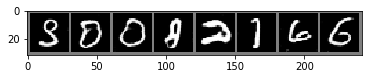

[1] Loss_D: 0.9930  Loss_G: 2.1735


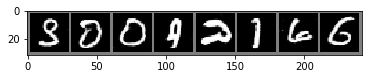

[2] Loss_D: 0.9042  Loss_G: 1.9745


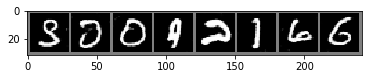

[3] Loss_D: 1.0463  Loss_G: 1.3352


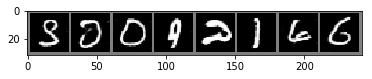

[4] Loss_D: 0.9895  Loss_G: 1.0826


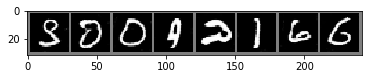

[5] Loss_D: 1.2461  Loss_G: 0.8778


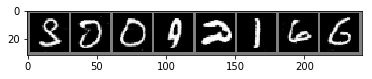

[6] Loss_D: 0.8303  Loss_G: 1.7280


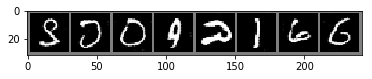

[7] Loss_D: 1.0058  Loss_G: 1.2116


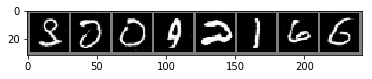

[8] Loss_D: 0.8262  Loss_G: 1.5788


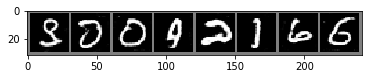

[9] Loss_D: 0.9614  Loss_G: 1.3504


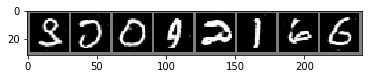

In [13]:
n_epoch = 10
n_show = 10000
n_save = 20

for epoch in range(n_epoch):
    for i, data in enumerate(trainloader, 0):
        # data[0] is images, data[1] is labels
        # Discriminator - real
        netD.zero_grad()
        
        real_data = data[0].to(device)
        batch_size = real_data.size(0)
        
        # This is a trick to use random number instead of 1.0 or 1.0. This is because at the begining, G won't
        # be generating realistic image and D might be able to discriminate it everytime and
        # leaving it with 0 zero to backprop.However, this didn't work well for this project.
        # https://github.com/soumith/ganhacks
        
        #real_labels = torch.rand((batch_size,), device=device)*0.5+0.7
        #g_real_labels = torch.rand((batch_size,), device=device)*0.5+0.7
        #fake_labels = torch.rand((batch_size,), device=device)*0.3
        
        real_labels = torch.full((batch_size,), 0.9, device=device)
        g_real_labels = torch.full((batch_size,), 0.9, device=device)
        fake_labels = torch.full((batch_size,), 0.1, device=device)                
        
        
        output = netD(real_data)
        loss_d_real = criterion(output, real_labels)
        loss_d_real.backward()
        
        # Discriminator - fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_data = netG(noise)
        
        # detach G's output i.e. fake_data from D so G does not get backprop
        output = netD(fake_data.detach())
        loss_d_fake = criterion(output, fake_labels)
        loss_d_fake.backward()        
        
        # Discriminator - update 2 backprop
        optimizerD.step()
        
        loss_d_total = loss_d_real + loss_d_fake
        #loss_d_total.backward()
        # Generator
        netG.zero_grad()
        output = netD(fake_data)
        loss_g = criterion(output, g_real_labels)
        loss_g.backward()
        
        optimizerG.step()
        
        
        # show image
        if i%n_show == 0:
            print('[%d] Loss_D: %.4f  Loss_G: %.4f'%(epoch, loss_d_total.item(), loss_g.item()))
            test_imgs = netG(fixed_noise)
            imshow(torchvision.utils.make_grid(test_imgs[0:8].detach().cpu()))
            
        if i%n_save == 0:
            torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % ('./models', epoch))
            torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % ('./models', epoch))